In [1]:
%matplotlib inline

from keras.datasets import mnist

import tensorflow as tf
import numpy as np
import os

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from matplotlib import pyplot as plt

from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, Adagrad
from PIL import Image
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.8.0


In [2]:
data_path = "data"

#We need a way to convert our training set into the correct format

def load_real_samples(image_path):
    
    #Defining master array
    master_list = list()

    for image in os.listdir(image_path):
        print(image)

        #loading image
        img = load_img(os.path.join(image_path,image))

        #Changing image size
        img = img.resize((200, 200), Image.ANTIALIAS)

        # convert to numpy array
        img_array = img_to_array(img)

        #img_array = tf.image.resize(img_array, [28, 28])
        #Standardizing to float
        img_array = img_array.astype("float32")
        #Getting value between 0 and 1
        img_array/=255.0

        master_list.append(img_array)

    return np.array(master_list)

array_data = load_real_samples(data_path)

9_1_2_20161219204347420.jpg.chip.jpg
1_1_2_20161219154612988.jpg.chip.jpg
16_0_0_20170104003740977.jpg.chip.jpg
1_1_3_20161219230734016.jpg.chip.jpg
26_1_1_20170103181931657.jpg.chip.jpg
2_0_2_20161219141650121.jpg.chip.jpg
53_1_0_20170110143534851.jpg.chip.jpg
36_1_4_20170104172843788.jpg.chip.jpg
37_0_0_20170104205628245.jpg.chip.jpg
10_0_1_20170110223848885.jpg.chip.jpg
1_0_2_20161219205313061.jpg.chip.jpg
52_0_0_20170104212337021.jpg.chip.jpg
18_1_0_20170109212830216.jpg.chip.jpg
34_1_3_20170104235537715.jpg.chip.jpg
34_1_4_20170103230336761.jpg.chip.jpg
34_1_0_20170104174537956.jpg.chip.jpg
30_0_0_20170104000150443.jpg.chip.jpg
75_1_3_20170110175327928.jpg.chip.jpg
24_1_2_20170104020224692.jpg.chip.jpg
86_1_0_20170110180113129.jpg.chip.jpg
3_0_3_20161219225157056.jpg.chip.jpg
54_1_0_20170110141340224.jpg.chip.jpg
60_1_0_20170110141610416.jpg.chip.jpg
1_0_2_20161219211357821.jpg.chip.jpg
59_0_0_20170111203940975.jpg.chip.jpg
41_1_0_20170104185117127.jpg.chip.jpg
3_1_4_2017010320511

In [ ]:
array_data

array([[[[0.3647059 , 0.41960785, 0.2901961 ],
         [0.3529412 , 0.40784314, 0.2784314 ],
         [0.34117648, 0.39607844, 0.26666668],
         ...,
         [0.07843138, 0.11764706, 0.08627451],
         [0.07450981, 0.11372549, 0.08235294],
         [0.07843138, 0.10588235, 0.07843138]],

        [[0.36078432, 0.41960785, 0.2901961 ],
         [0.3529412 , 0.40784314, 0.2784314 ],
         [0.3372549 , 0.39215687, 0.2627451 ],
         ...,
         [0.07843138, 0.11764706, 0.08627451],
         [0.08235294, 0.10980392, 0.08235294],
         [0.07843138, 0.10588235, 0.07843138]],

        [[0.35686275, 0.41568628, 0.28627452],
         [0.34901962, 0.40784314, 0.2784314 ],
         [0.3372549 , 0.39215687, 0.2627451 ],
         ...,
         [0.07843138, 0.11764706, 0.08627451],
         [0.07843138, 0.10588235, 0.07843138],
         [0.07843138, 0.10588235, 0.07843138]],

        ...,

        [[0.18039216, 0.2509804 , 0.14901961],
         [0.18431373, 0.25490198, 0.16078432]

In [ ]:
#Defining image shape

img_rows = 200
img_cols = 200
channels = 3

img_shape = (img_rows, img_cols, channels)

In [ ]:
def build_generator():
    noise_shape = (1000,) #Defining the latent vector of size 100

    #Defining our model with 4 dense layers of increasing dimension
    model = Sequential()

    model.add(Dense(256, input_shape = noise_shape))
    model.add(ReLU())
    model.add(BatchNormalization(momentum = 0.8))

    model.add(Dense(512))
    model.add(ReLU())
    model.add(BatchNormalization(momentum = 0.8))

    model.add(Dense(1024))
    model.add(ReLU())
    model.add(BatchNormalization(momentum = 0.8))

    model.add(Dense(2048))
    model.add(ReLU())
    model.add(BatchNormalization(momentum = 0.8))

    model.add(Dense(np.prod(img_shape), activation = "tanh"))
    model.add(Reshape(img_shape))

    model.summary()

    #Transforming the latent space vector into an tf input
    noise = Input(shape = noise_shape)
    #Feeding that latent space into the model to create an image
    img = model(noise) #Generated image

    return Model(noise, img)


In [ ]:
#Building a discriminator to guess at whether an image is real or not
#Model has 4 layers of decreasing dimension

def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(1024))

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))

    model.add(ReLU())
    model.add(Dense(256))
    
    model.add(ReLU())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    #Converting the image into a tf input and passing that to the model
    img = Input(shape=img_shape)
    #Retrieving the output prediction from the model
    validity = model(img)

    return Model(img, validity) #The validity is whether or not the model thinks the image is real
    

In [ ]:
def train(dataset, epochs, batch_size=128, save_interval=500):
    
    half_batch = int(batch_size / 2)

    disc_accuracy_list = []
    disc_loss_list = []
    generator_loss_list = []
    epoch_list = []

    for epoch in range(epochs):
        
        # ---------------------
        #  Discriminator Training
        # ---------------------

        # Select a random half batch of real images from our array data stored in array_data

        #Storing the indexes of those images in idx
        indx = np.random.randint(0, array_data.shape[0], half_batch)

        #Retreiving those indexes from the array
        imgs = array_data[indx]

        #Generating a half batch worth of latent space vectors which will comprise half of what
        #we feed to the discriminator
        latent_space = np.random.normal(0, 1, (half_batch, 1000))
        
        # Generate a half batch of fake images from the half batch of latent spaces
        generated_imgs = generator.predict(latent_space)

        # Training the discriminator on real and fake images but not at the same time, always holding one constant
        #first on the real
        disc_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))

        #then on the fake generated images
        disc_loss_fake = discriminator.train_on_batch(generated_imgs, np.zeros((half_batch, 1)))

        #take average loss from real and fake images. 
        disc_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake) 

        #Now within the same for loop we train our Generator model by setting the input latent_space and
        #ultimately training the Generator to have the Discriminator label its samples as valid or false.
        
        # ---------------------
        #  Train Generator
        # ---------------------

        #Create latent_space vectors as input for generator. 
        #Create as many latent_space vectors as defined by the batch size. 
        latent_space = np.random.normal(0, 1, (batch_size, 1000)) 

        #Creating a vector of ones in order to trick the discriminator into thinking that the image is real
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of the combined model where it paired with the discriminator
        # Train the generator with latent_space as x and 1 as y. 
        generator_loss = combined.train_on_batch(latent_space, valid_y)


        #In order for us to keep track of the epochs elapsed and the results we print the following
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, disc_loss[0], 100*disc_loss[1], generator_loss))

        #Appending the loss and accuracy metrics to lists
        epoch_list.append(epoch)
        disc_loss_list.append(disc_loss[0])
        disc_accuracy_list.append(100*disc_loss[1])
        generator_loss_list.append(generator_loss)

        # If we are at the specified interval save generated image of samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

    #At the end of the epochs plot the discriminator loss per epoch
    plt.plot(epoch_list, disc_loss_list)
    plt.show()

def save_imgs(epoch):
    r, c = 5, 5
    latent_space = np.random.normal(0, 1, (r * c, 1000))
    generated_imgs = generator.predict(latent_space)

    # Scaling our image
    generated_imgs = 0.5 * generated_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(generated_imgs[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/model_5generation_%d.png" % epoch)
    plt.close()

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-04-15 10:12:11.391235: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-15 10:12:11.391368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 120000)            0         
                                                                 
 dense (Dense)               (None, 1024)              122881024 
                                                                 
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 re_lu_1 (ReLU)              (None, 256)               0

2022-04-15 10:12:11.870902: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-15 10:12:11.923096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 10:12:12.266242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-15 10:12:12.888404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0 [D loss: 0.632404, acc.: 46.88%] [G loss: 0.559352]


2022-04-15 10:12:14.011850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1 [D loss: 0.382932, acc.: 50.00%] [G loss: 0.364979]
2 [D loss: 0.404919, acc.: 50.00%] [G loss: 0.173225]
3 [D loss: 0.497089, acc.: 50.00%] [G loss: 0.091843]
4 [D loss: 0.414845, acc.: 64.84%] [G loss: 0.059453]
5 [D loss: 0.173423, acc.: 99.22%] [G loss: 0.056948]
6 [D loss: 0.106679, acc.: 98.44%] [G loss: 0.043522]
7 [D loss: 0.120546, acc.: 97.66%] [G loss: 0.070974]
8 [D loss: 0.306411, acc.: 86.72%] [G loss: 0.173467]
9 [D loss: 0.929910, acc.: 67.97%] [G loss: 0.881244]
10 [D loss: 1.031793, acc.: 71.88%] [G loss: 1.369589]
11 [D loss: 1.439028, acc.: 62.50%] [G loss: 2.098211]
12 [D loss: 1.192158, acc.: 66.41%] [G loss: 2.832476]
13 [D loss: 1.066836, acc.: 64.06%] [G loss: 3.984209]
14 [D loss: 0.671022, acc.: 75.78%] [G loss: 4.135074]
15 [D loss: 0.386449, acc.: 81.25%] [G loss: 4.923635]
16 [D loss: 11.920416, acc.: 21.09%] [G loss: 4.256127]
17 [D loss: 2.026250, acc.: 72.66%] [G loss: 4.428545]
18 [D loss: 1.285910, acc.: 79.69%] [G loss: 6.403256]
19 [D loss: 0.8682

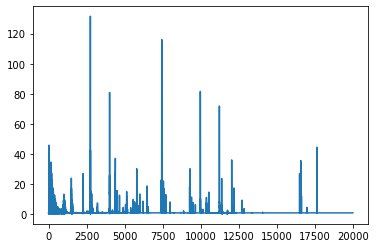

In [ ]:
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# We are first going to build the discriminator and then train the generator as part of the combined model later
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#Building and compiling our Generator, picking the loss function and optimizer
#Since we are generating fake images there is no need to track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

#Creating first the input latent space and then defining the generator  
z = Input(shape=(1000,))   #Our random vector to be used as an input

#Storing the image as img
img = generator(z)

#Ensuring that when we combine Discriminator and Generator networks we only train the latter 
#This is to ensure that while the generator is being trained, the weights of the discriminator are not being adjusted
#Note that this has no impact on the discriminator training above    
discriminator.trainable = False  

#Here our generator takes our image and classifies it as either real or fake  
r_or_f = discriminator(img) 

#Here we combine the gen and disc models and define our loss function and optimizer. 
#To be sure, we are only training the generator here-
#The objective in this step is for the generator to fool the discriminator  
# The final combined model  (which is a stacked generator and discriminator) takes
# noise (latent space) as an input => generates images => determines the validity of those images
combined = Model(z, r_or_f)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

#Setting the model with the needed params
train(array_data,epochs=20000, batch_size=256, save_interval=500)

#Saving model for future use
generator.save('image_generator_model.h5')